<a href="https://colab.research.google.com/github/Kaichao-Zheng/CITS4012-NLP/blob/main/CITS4012_Group9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2025 CITS4012 Group 9 Assignment

**Collaborators**

| Uni ID   | Student Name  | GitHub Username                                   |
| -------- | ------------- | ------------------------------------------------- |
| 24141207 | Kaichao Zheng | [Kaichao-Zheng](https://github.com/Kaichao-Zheng) |
| 24645175 | Ziqi Meng     | [jiongge39](https://github.com/jiongge39)         |
| 23998001 | Yanglei Yuan  | [LeoYuan0225](https://github.com/LeoYuan0225)     |

# Readme
这是Project 1的模板，我直接拿来用了

仅需注重代码风格及可视化，让marker改起来舒服就行，分数低不了的
* 例如：多抄Lab的技术栈，多引用学界的基石论文，marker自然乐意审自己熟悉的技术。e.g., WordCloud Visualization

*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object *Oriented* Programming style, please put those the bottom of this ipynb file*

# 0. Setup

> NOTE:
>
> In Google Colab, an ERROR would occur due to incompatibility of the latest versions of `numpy` and `scipy`.
>
> Simply **restart the runtime** to use the newly downgraded versions.

In [18]:
%pip install word2number
%pip install contractions
%pip install nltk
%pip install pandas
%pip install gensim
%pip install matplotlib
%pip install wordcloud
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu118
  Obtaining dependency information for torch from https://download.pytorch.org/whl/cu118/torch-2.7.1%2Bcu118-cp310-cp310-win_amd64.whl.metadata
  Using cached https://download.pytorch.org/whl/cu118/torch-2.7.1%2Bcu118-cp310-cp310-win_amd64.whl.metadata (27 kB)
  Obtaining dependency information for torchvision from https://download.pytorch.org/whl/cu118/torchvision-0.22.1%2Bcu118-cp310-cp310-win_amd64.whl.metadata
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.22.1%2Bcu118-cp310-cp310-win_amd64.whl.metadata (6.3 kB)
  Obtaining dependency information for torchaudio from https://download.pytorch.org/whl/cu118/torchaudio-2.7.1%2Bcu118-cp310-cp310-win_amd64.whl.metadata
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.7.1%2Bcu118-cp310-cp310-win_amd64.whl.metadata (6.8 kB)
  Obtaining dependency information for filelock from https://download.pytorch.org/whl/filelock-3.19.1-py3-none-any.whl.me


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# 1. Overview

We implemented three substantially different model architectures:

* [The Vanilla Bi-LSTM NLI Classifier](#scrollTo=67TQJgOJ_lF1)

* [Model 2](#scrollTo=BhSE5ON4_r0C)

* [Model 3](#scrollTo=E4w_n2P2_xxm)

# 2. Data Preprocessing

## 2.1 Load JSON files from GitHub



In [19]:
# Define JSON dataset paths
base_url = "https://raw.githubusercontent.com/Kaichao-Zheng/CITS4012-NLP/main/"

train_file = base_url + "train.json"
val_file = base_url + "validation.json"
test_file = base_url + "test.json"

# Quick check
print("✅ Dataset URLs:")
print("Train:\t", train_file)
print("Val:\t", val_file)
print("Test:\t", test_file)

✅ Dataset URLs:
Train:	 https://raw.githubusercontent.com/Kaichao-Zheng/CITS4012-NLP/main/train.json
Val:	 https://raw.githubusercontent.com/Kaichao-Zheng/CITS4012-NLP/main/validation.json
Test:	 https://raw.githubusercontent.com/Kaichao-Zheng/CITS4012-NLP/main/test.json


In [20]:
import pandas as pd

# Working dataframes
train_df = pd.read_json(train_file)
val_df = pd.read_json(val_file)
test_df = pd.read_json(test_file)

# Keep original copies
source_train_df = train_df.copy()
source_val_df = val_df.copy()
source_test_df = test_df.copy()

# Sneak peek
pd.set_option("display.max_colwidth", 30)

print(train_df.head())
# print(val_df.head())
# print(test_df.head())

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

pd.reset_option("display.max_colwidth")

                         premise                     hypothesis    label
0  Pluto rotates once on its ...  Earth rotates on its axis ...  neutral
1  ---Glenn =================...  Earth rotates on its axis ...  entails
2  geysers - periodic gush of...  The surface of the sun is ...  neutral
3  Facts: Liquid water drople...  Evaporation is responsible...  entails
4  By comparison, the earth r...  Earth rotates on its axis ...  entails
Train size: 23088
Val size: 1304
Test size: 2126


## 2.2 Define difference viewer

In [21]:
import html
from difflib import SequenceMatcher
from IPython.display import display, HTML

def verify_print(source_df, cleaned_df, tag, num, col, idx_src ,idx_now, kept=False):
  status = "Kept " if kept else "Reindexed"
  print(f"{tag} {num}:\tidx_src: {idx_src}\t{source_df[col][idx_src]}")
  print(f"{status} {num}:\tidx_now: {idx_now}\t{cleaned_df[col][idx_now]}")
  print()

# You can enable dark mode by replacing default "light" here
def verify_diff(source_df, cleaned_df, tag, num, col, index, kept=False, theme="dark"):
  if theme == "light":
    bg = "#fafafa"; fg = "#000000"
    del_bg = "#ffdddd"; ins_bg = "#ddffdd"
    del_fg = "#aa0000"; ins_fg = "#006600"
  else:
    bg = "#1e1e1e"; fg = "#e0e0e0"
    del_bg = "#662222"; ins_bg = "#224422"
    del_fg = "#ff9999"; ins_fg = "#99ff99"

  status = "Kept" if kept else "Fixed"

  original = source_df[col][index]
  cleaned = cleaned_df[col][index]

  matcher = SequenceMatcher(None, original, cleaned)

  html_original = f"""
  <div style='margin-bottom: 10px; background-color:{bg}; color:{fg}; white-space: nowrap; font-family: monospace; padding: 5px; border-radius:4px;'>
  <b>{tag} {num}:</b> """
  html_cleaned = f"""
  <div style='margin-bottom: 10px; background-color:{bg}; color:{fg}; white-space: nowrap; font-family: monospace; padding: 5px; border-radius:4px;'>
  <b>{status} {num}:</b> """

  for tag, i1, i2, j1, j2 in matcher.get_opcodes():
    orig_text = original[i1:i2].replace(" ", "&nbsp;")
    clean_text = cleaned[j1:j2].replace(" ", "&nbsp;")

    if tag == 'equal':
      html_original += orig_text
      html_cleaned += clean_text
    elif tag == 'delete':
      html_original += f"<span style='background-color:{del_bg}; color:{del_fg};'>{orig_text}</span>"
    elif tag == 'insert':
      html_cleaned += f"<span style='background-color:{ins_bg}; color:{ins_fg};'>{clean_text}</span>"
    elif tag == 'replace':
      html_original += f"<span style='background-color:{del_bg}; color:{del_fg};'>{orig_text}</span>"
      html_cleaned += f"<span style='background-color:{ins_bg}; color:{ins_fg};'>{clean_text}</span>"

  html_original += "</div>"
  html_cleaned += "</div>"

  display(HTML(html_original + html_cleaned + "<hr/>"))

## 2.3 Data cleansing

In principle, the data cleansing rules are derived solely from the training set to prevent information leakage.

This design intentionally preserves out-of-vocabulary (OOV) cases in the validation and test sets, which are represented by \<UNK> tag.

Assumption
* The value of `label` is binary, either "neutral" or "entails".

Compromises
* Ignore syntactic errors and semantic errors.
* Apply unified premises rules on hypothesis.

Handled Issues
| No. | Description | Examples |
|----------|-------------|-----------|
| Issue 1 | HTML/XML tags with ID pattern | train premise 78, 270, 319, ... |
| Issue 2 | Non-linguistic long/pure separators | train premise 1, 382, 385, ... |
| Issue 3 | Duplicate consecutive phrases | train premise 78, 87, 564, ... |
| Issue 4 | Single-word sentences  | train premise 146, 181, 427, ... |
| Issue 5 | Duplicated whitespaces | train premise 123, 193, 259, ... |
| Issue 6 | Spaces before punctuations, except '!' and '?' | train premise 3, 333, 6280 |
| Issue 7 | Premise with long concatenated sentences | train premise 270, 537, 608, ... |

Kept Noises

| No. | Description | Noise | Non-Noise |
|----------|-------------|----------|--------------|
| Noise 1 | Instructional prompt words | train premise 3, 61, 319, ... | train premise 16, 24, 61, ... |
| Noise 2 | Numbered markers | train premise 270, 537, 608, ... | train premise 1546, 2068, ... |
| Noise 3 | Misplaced `label` values | train premise 270, 537, 606, ... | train premise 1683, 2068, ... |
| Noise 4 | Metadata prefixes | train premise 32, 230, 482, ... |  |
| Noise 5 | Isolated single symbols | train premise 60, 1185 | comparison operators |


Limitation

The difference viewer automatically escapes HTML entities, which might overlook HTML noise. (E.g., &amp;quot; in train premise 420)

In [22]:
import re

def cleanse(df):
  df = df.copy()

  ID_PATTERN = r"\b[A-Za-z]?(?:\d{6,}|[A-Za-z0-9]{8,})(?:-[A-Za-z0-9]{2,})+\b"
  REPEAT_PATTERN = r"\b((?:\w+\s+){0,2}\w+)( \1\b)+"

  for col in ["premise", "hypothesis"]:

    # pre-trim: two-tailed whitespaces
    df[col] = df[col].apply(lambda x: x.strip())

    # issue 1: HTML/XML tags with ID pattern
    df[col] = df[col].apply(html.unescape)
    df[col] = df[col].apply(lambda x: re.sub(r"<[^>]*>", " ", x))
    df[col] = df[col].apply(lambda x: re.sub(ID_PATTERN, " ", x))

    # issue 2: non-linguistic long/pure separators
    df[col] = df[col].apply(lambda x: re.sub(r"[-=*_~$]{3,}", " ", x))
    df[col] = df[col].apply(lambda x: "" if re.fullmatch(r"[\W_]+", x.strip()) else x)

    # issue 3: duplicate consecutive phrases
    df[col] = df[col].apply(lambda x: re.sub(REPEAT_PATTERN, r"\1", x))

    # issue 4: single-word sentences
    df[col] = df[col].apply(lambda x: "" if re.fullmatch(r"(\w+[.!?']?|[^\w\s]+)", x.strip()) else x)

    # issue 5: duplicate whitespaces
    df[col] = df[col].apply(lambda x: re.sub(r"\s+", " ", x).strip())

    # issue 6: spaces before punctuations
    df[col] = df[col].apply(lambda x: re.sub(r"\s+([.,;:])", r"\1", x))

  return df

# Clenasing
train_df = cleanse(train_df)
val_df = cleanse(val_df)
test_df = cleanse(test_df)

# Keep cleaned copies
cleaned_train_df = train_df.copy()
cleaned_val_df = val_df.copy()
cleaned_test_df = test_df.copy()

# Verification
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=1, col="premise", index=319)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=2, col="premise", index=1)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=3, col="premise", index=87)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=4, col="premise", index=146)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=5, col="premise", index=123)
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=6, col="premise", index=3)
# verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=6, col="premise", index=6280, kept=True)  # why except '?'
# verify_diff(source_train_df, cleaned_train_df, tag="Issue", num=6, col="premise", index=333, kept=True)  # why except '!'
verify_diff(source_train_df, cleaned_train_df, tag="Issue", num="Hybrid", col="premise", index=270)

## 2.4 Normalization

In [23]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
sww = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
import re, contractions
from nltk.tokenize import word_tokenize, sent_tokenize
from word2number import w2n
from contractions import fix as expand_contractions

def word2num(text):
  def convert(match):
    word = match.group(0)
    try:
      return f" {w2n.word_to_num(word)} "
    except:
      return f" {word} "
  text = re.sub(
    r'\b(?:zero|one|two|three|four|five|six|seven|eight|nine|ten|'
    r'eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|'
    r'eighteen|nineteen|twenty|thirty|forty|fifty|sixty|seventy|'
    r'eighty|ninety|hundred|thousand|million|billion|and|[- ])+\b',
    convert, text)
  return ' '.join(text.split())

def normalize(df):
  df = df.copy()

  for col in ["premise", "hypothesis"]:

    # rule 1: lowercase
    df[col] = df[col].str.lower()

    # rule 2: expand contraction
    df[col] = df[col].apply(expand_contractions)

    # rule -1: remove stopwords
    # df[col] = df[col].apply(lambda x: " ".join([w for w in word_tokenize(x) if w.lower() not in sww]))

    # rule -2: remove bracketed content
    # df[col] = df[col].apply(lambda x: re.sub(r'\([^)]*\)', '', x))

    # rule -3: symbolize linguistic numbers
    # df[col] = df[col].apply(word2num)

  return df

# Normalization
train_df = normalize(train_df)
val_df = normalize(val_df)
test_df = normalize(test_df)

# Keep normalized copies
normalized_train_df = train_df.copy()
normalized_val_df = val_df.copy()
normalized_test_df = test_df.copy()

# Verification
verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num="1", col="premise", index=1)
verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num="2", col="premise", index=420)
verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num="2", col="hypothesis", index=8, kept=True)

# Inactivate rules
# verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num=-1, col="premise", index=1, kept=True)
# verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num=-2, col="premise", index=8, kept=True)
# verify_diff(cleaned_train_df, normalized_train_df, tag="Rule", num=-3, col="premise", index=147, kept=True)

## 2.5 Reindexing

In [25]:
def reindex(df):
  df = df.copy()

  for col in ["premise", "hypothesis"]:

    # post-issue 4: remove rows with empty cell
    df = df[df[col].astype(str).str.strip() != ""]

  # issue 7: premise with long concatenated sentences
  new_rows = []
  for _, row in df.iterrows():
    premise = str(row["premise"]).strip()
    hypothesis = str(row["hypothesis"]).strip()
    label = str(row["label"]).strip()

    if not premise:
      continue

    # split by ". " or "; " to avoid 3.14
    sentences = re.split(r'(?<!\d)(?<=[.;])\s+(?=[A-Za-z])', premise)
    sentences = [s.strip() for s in sentences if s.strip()]

    for s in sentences:
      new_rows.append({
        "premise": s,
        "hypothesis": hypothesis,
        "label": label
      })
  df = pd.DataFrame(new_rows)

  # reorder index
  df = df.reset_index(drop=True)

  return df

# Reindexing
train_df = reindex(train_df)
val_df = reindex(val_df)
test_df = reindex(test_df)

# Keep reindexed copies
reindexed_train_df = train_df.copy()
reindexed_val_df = val_df.copy()
reindexed_test_df = test_df.copy()

# Verification
verify_print(normalized_train_df, reindexed_train_df, tag="Post-Issue", num=4, col="premise", idx_src=147, idx_now=158)
verify_print(normalized_train_df, reindexed_train_df, tag="Issue", num=7, col="premise", idx_src=31, idx_now=31, kept=True)
verify_print(normalized_train_df, reindexed_train_df, tag="Issue", num=7, col="premise", idx_src=270, idx_now=281)

Post-Issue 4:	idx_src: 147	j 535.4 b the apple pie tree by zoe hall two sisters watch their backyard apple tree grow leaves, flowers, and fruit.
Reindexed 4:	idx_now: 158	j 535.4 b the apple pie tree by zoe hall two sisters watch their backyard apple tree grow leaves, flowers, and fruit.

Issue 7:	idx_src: 31	slugs, believe it or not have a very important purpose. they are decomposers, which means they eats wastes and organic materials of other organisms. they help get rid of the t…rash that animals leave behind.
Kept  7:	idx_now: 31	slugs, believe it or not have a very important purpose.

Issue 7:	idx_src: 270	when the national academy of sciences published a guide on teaching evolution last month, it was no accident, then, that it also focused on what teachers should know and explain to students about the nature of science. if an accident happens during a science experiment, the first thing a student should do is report to the teacher. neutral an accident happens during a science exp

## 2.6 Tokenization

In [26]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [27]:
import string

def protect_float(text: str) -> str:
  return re.sub(r"(?<=\d)\.(?=\d)", "DOTTK", text)

def recover_float(tokens):
  return [t.replace("DOTTK", ".") for t in tokens]

def tokenize(df):
  df = df.copy()
  KEEP_SYMBOLS = set("=<>+-/*%!")

  for col in ["premise", "hypothesis"]:
    # Remove punctuations
    df[col] = df[col].apply(lambda x: protect_float(x))
    df[col] = df[col].apply(lambda x: [t for t in word_tokenize(x) if t not in string.punctuation or t in KEEP_SYMBOLS])
    df[col] = df[col].apply(lambda toks: recover_float(toks))

  return df

# Tokenization
tokenized_train_df = tokenize(train_df)
tokenized_val_df = tokenize(val_df)
tokenized_test_df = tokenize(test_df)

# Quick check
preview_rows = pd.concat([
  tokenized_train_df.head(),
  tokenized_train_df.iloc[[6, 23, 34, 62, 369, 438, 2116]]  # concatenate indeces 6, 23, 32, 60, 319, 385, 1185
])

display(preview_rows)

,premise,hypothesis,label
0,"[pluto, rotates, once, on, its, axis, every, 6...","[earth, rotates, on, its, axis, once, times, i...",neutral
1,"[glenn, once, per, day, the, earth, rotates, a...","[earth, rotates, on, its, axis, once, times, i...",entails
2,"[geysers, -, periodic, gush, of, hot, water, a...","[the, surface, of, the, sun, is, much, hotter,...",neutral
3,"[facts, liquid, water, droplets, can, be, chan...","[evaporation, is, responsible, for, changing, ...",entails
4,"[by, comparison, the, earth, rotates, on, its,...","[earth, rotates, on, its, axis, once, times, i...",entails
6,"[it, takes, pluto, 247.7, earth, years, to, ma...","[earth, makes, a, complete, revolution, around...",neutral
23,"[3, the, earth, is, far, enough, from, the, su...","[the, surface, of, the, sun, is, much, hotter,...",neutral
34,"[i, 4.4.3d, different, forms, of, energy, incl...","[heat, light, and, sound, are, all, different,...",entails
62,"[>, >, it, is, turned, into, plasma, a, burnin...","[the, surface, of, the, sun, is, much, hotter,...",neutral
369,"[electricity, part, 4, series, and, parallel, ...","[a, parallel, circuit, is, best, described, as...",neutral


## 2.7 Visualisation via Word Cloud

We actually include stopwords in the tokenized dataframes for model training,

but temporarily remove them here for visualisation purposes.

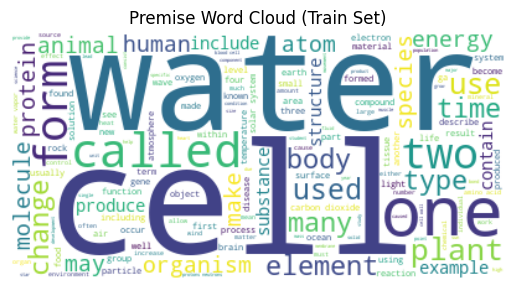

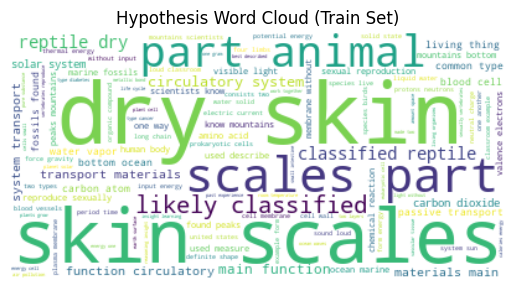

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
sww = stopwords.words('english')

for col in ["premise", "hypothesis"]:
  tokens = []
  # Remove punctuation, number, and stopword tokens temporarily
  for toks in tokenized_train_df[col]:
    tokens.extend([t.lower() for t in toks if t.isalpha() and t.lower() not in sww])
  wordcloud = WordCloud(background_color="white").generate(" ".join(tokens))
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(f"{col.capitalize()} Word Cloud (Train Set)")
  plt.show()

# 3. Word Embedding

## 3.1 Token vocabulary

The vocabulary only includes tokens in train set with `frequency >= 3`.

Therefore, a token with low frequency will be regarded as \<UNK>.

E.g. the token "6.39" from the first premise.

In [29]:
from collections import Counter

def build_vocab(df, min_freq=3):
  counter = Counter()
  for col in ["premise", "hypothesis"]:
    for toks in df[col]:
      counter.update(toks)

  # special tokens
  vocab = {"<PAD>": 0,"<UNK>": 1}
  for token, freq in counter.items():
    if freq >= min_freq and token not in vocab:
      vocab[token] = len(vocab)

  return vocab

vocab = build_vocab(tokenized_train_df)
print("Vocab size:\t", {len(vocab)})
print("Sample vocab:\t", list(vocab.keys())[:20])

Vocab size:	 {8716}
Sample vocab:	 ['<PAD>', '<UNK>', 'pluto', 'rotates', 'once', 'on', 'its', 'axis', 'every', 'earth', 'days', 'per', 'day', 'the', 'about', 'geysers', '-', 'periodic', 'of', 'hot']


## 3.3 One-hot key embedding

Map each token to its one-hot key from the vocabulary.

In [30]:
def word_to_index(df, vocab):
  df = df.copy()

  for col in ["premise", "hypothesis"]:
    df[col] = df[col].apply(lambda toks: [vocab.get(w, vocab["<UNK>"]) for w in toks])

  label_map = {"neutral": 0, "entails": 1}
  if "label" in df.columns:
    df["label"] = df["label"].map(label_map).fillna(-1).astype(int)

  return df

# One-hot key embedding
indexed_train_df = word_to_index(tokenized_train_df, vocab)
indexed_val_df = word_to_index(tokenized_val_df, vocab)
indexed_test_df = word_to_index(tokenized_test_df, vocab)

display(indexed_train_df.head())

,premise,hypothesis,label
0,"[2, 3, 4, 5, 6, 7, 8, 1, 9, 10]","[9, 3, 5, 6, 7, 4, 46, 75, 58, 12]",0
1,"[1, 4, 11, 12, 13, 9, 3, 14, 6, 7]","[9, 3, 5, 6, 7, 4, 46, 75, 58, 12]",1
2,"[15, 16, 17, 1, 18, 19, 20, 21, 13, 22, 18, 13...","[13, 22, 18, 13, 42, 44, 185, 1185, 50, 1049, ...",0
3,"[23, 24, 20, 25, 26, 27, 28, 29, 30, 20, 31, 3...","[36, 44, 2057, 55, 547, 24, 20, 29, 20, 31]",1
4,"[37, 38, 13, 9, 3, 5, 6, 7, 4, 11, 12, 39, 40,...","[9, 3, 5, 6, 7, 4, 46, 75, 58, 12]",1


# 4. Model Implementation

## 4.1 Training Configuration

### 4.1.1 Enable cuda GPU acceleration

In [31]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 4.1.2 Shared hyperparameters


In [32]:
from types import SimpleNamespace

shared = SimpleNamespace(
  vocab_size = len(vocab),
  embed_dim = 256,
  hidden_dim = 256,
  num_layers = 1,
  dropout = 0.1,
  num_classes = 2,      # "neutral": 0, "entails": 1
  batch_size = 128,
  learning_rate = 1e-3,
  total_epoch = 20,
  pad_idx = vocab["<PAD>"],
  unk_idx = vocab["<UNK>"],
)

### 4.1.3 Padding

In [33]:
def pad(seq, max_len):
  return seq + [shared.pad_idx] * (max_len - len(seq))

def pad_seq(df):
  df = df.copy()

  max_prem = max(df["premise"].apply(len))
  max_hypo = max(df["hypothesis"].apply(len))

  df["premise"] = df["premise"].apply(lambda s: pad(s, max_prem))
  df["hypothesis"] = df["hypothesis"].apply(lambda s: pad(s, max_hypo))

  return df

# Padding
pad_train_df = pad_seq(indexed_train_df)
pad_val_df = pad_seq(indexed_val_df)
pad_test_df = pad_seq(indexed_test_df)

# Verification
pd.set_option("display.max_colwidth", 60)
display(pad_train_df.head())
pd.reset_option("display.max_colwidth")

,premise,hypothesis,label
0,"[2, 3, 4, 5, 6, 7, 8, 1, 9, 10, 0, 0, 0, 0, 0, 0, 0, 0, ...","[9, 3, 5, 6, 7, 4, 46, 75, 58, 12, 0, 0, 0, 0, 0, 0, 0, ...",0
1,"[1, 4, 11, 12, 13, 9, 3, 14, 6, 7, 0, 0, 0, 0, 0, 0, 0, ...","[9, 3, 5, 6, 7, 4, 46, 75, 58, 12, 0, 0, 0, 0, 0, 0, 0, ...",1
2,"[15, 16, 17, 1, 18, 19, 20, 21, 13, 22, 18, 13, 9, 0, 0,...","[13, 22, 18, 13, 42, 44, 185, 1185, 50, 1049, 1776, 5, 9...",0
3,"[23, 24, 20, 25, 26, 27, 28, 29, 30, 20, 31, 32, 33, 34,...","[36, 44, 2057, 55, 547, 24, 20, 29, 20, 31, 0, 0, 0, 0, ...",1
4,"[37, 38, 13, 9, 3, 5, 6, 7, 4, 11, 12, 39, 40, 41, 13, 4...","[9, 3, 5, 6, 7, 4, 46, 75, 58, 12, 0, 0, 0, 0, 0, 0, 0, ...",1


### 4.1.4 Batching

In [34]:
from torch.utils.data import TensorDataset, DataLoader

def make_batch(pad_df):
  batch_size = shared.batch_size

  premises_tensor = torch.tensor(pad_df["premise"].tolist())
  hypotheses_tensor = torch.tensor(pad_df["hypothesis"].tolist())
  labels_tensor = torch.tensor(pad_df["label"].tolist())

  dataset = TensorDataset(premises_tensor, hypotheses_tensor, labels_tensor)
  loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  return loader

train_loader = make_batch(pad_train_df)
val_loader = make_batch(pad_val_df)

## 4.2 The Vanilla Bi-LSTM NLI Classifier

This model is inspired by the classic SNLI model proposed by [Bowman et al.](https://arxiv.org/abs/1508.05326)
* Single recurrent (LSTM) layer
* Dropout applied to encoders and classifier
* The value of `label` is either "neutral" or "entails"
* Validation set used for monitoring overfitting
* Remains affected by the OOV limitation
* No attention mechanism

### 4.2.1 Model

In [35]:
import torch.nn as nn

class Vanilla_NLI_Model(nn.Module):
  def __init__(self, shared):
    super().__init__()

    # Embedding layer
    self.prem_embedding = nn.Embedding(shared.vocab_size, shared.embed_dim, padding_idx=shared.pad_idx) # discard <PAD>
    self.hypo_embedding = nn.Embedding(shared.vocab_size, shared.embed_dim, padding_idx=shared.pad_idx) # discard <PAD>

    # Encoding Layer
    self.encoder = nn.LSTM(
      input_size=shared.embed_dim,
      hidden_size=shared.hidden_dim,
      num_layers=shared.num_layers,                  # single recurrent layer
      dropout=shared.dropout if shared.num_layers > 1 else 0.0, # disabled， dropout only applies between recurrent layers
      bidirectional=True,                       # Bi-LSTM
      batch_first=True                        # (B, T, E)
    )

    # Regularization to prevent overfitting
    self.dropout_encoder = nn.Dropout(shared.dropout)

    # Classification layer
    feat_dim = 2 * (2 * shared.hidden_dim)            # (prem + hypo) × BiLSTM(2H each) = 4H
    self.classifier = nn.Linear(feat_dim, shared.num_classes)    # simplest linear classifier

  def forward(self, prem_ids, hypo_ids):
    # Encode premise
    prem_embed = self.prem_embedding(prem_ids)            # (B, T_p, E)
    _, (prem_h, _) = self.encoder(prem_embed)           # return encoder_output, (prem_hidden_state, prem_cell_state)
    # Concat two-direction final hidden states
    prem_vec = torch.cat([prem_h[-2], prem_h[-1]], dim=1)     # (B, 2H)
    prem_vec = self.dropout_encoder(prem_vec)            # apply dropout to concatenated premise hidden state

    # Encode hypothesis
    hypo_embed = self.hypo_embedding(hypo_ids)            # (B, T_h, E)
    _, (hypo_h, _) = self.encoder(hypo_embed)           # return encoder_output, (hypo_hidden_state, hypo_cell_state)
    # Concat two-direction final hidden states
    hypo_vec = torch.cat([hypo_h[-2], hypo_h[-1]], dim=1)     # (B, 2H)
    hypo_vec = self.dropout_encoder(hypo_vec)            # apply dropout to concatenated hypothesis hidden state

    # Combine premise and hypothesis as unified input for classifier
    combined = torch.cat([prem_vec, hypo_vec], dim=1)       # (B, 4H)
    combined = self.dropout_encoder(combined)            # apply dropout to combined premise-hypothesis representation

    # Classification
    logits = self.classifier(combined)                # (B, shared.num_classes)

    return logits

### 4.2.2 Training (3 min)

In [36]:
import torch.optim as optim

model = Vanilla_NLI_Model(shared).to(device)
criterion = nn.CrossEntropyLoss()      # combine LogSoftmax and NLLLoss
optimizer = optim.Adam(model.parameters(), lr=shared.learning_rate)

In [37]:
train_epoch_losses = []
val_epoch_losses = []

for epoch in range(shared.total_epoch):
  model.train()
  train_loss = 0

  # Training loop
  for prem, hypo, label in train_loader:
    prem, hypo, label = prem.to(device), hypo.to(device), label.to(device)

    # Forward
    logits = model(prem, hypo)
    loss = criterion(logits, label)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Accumulate batch loss
    train_loss += loss.item()

  train_avg_loss = train_loss / len(train_loader)
  train_epoch_losses.append(train_avg_loss)

  # Validation
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for prem, hypo, label in val_loader:
      prem, hypo, label = prem.to(device), hypo.to(device), label.to(device)

      # Forward
      logits = model(prem, hypo)
      loss = criterion(logits, label)

      # Accumulate batch loss
      val_loss += loss.item()

  val_avg_loss = val_loss / len(val_loader)
  val_epoch_losses.append(val_avg_loss)

  print(f"Epoch: {epoch+1}/{shared.total_epoch}\tTrain Loss: {train_avg_loss:.4f}\tVal Loss: {val_avg_loss:.4f}")

Epoch: 1/20	Train Loss: 0.4725	Val Loss: 0.5347
Epoch: 2/20	Train Loss: 0.3261	Val Loss: 0.5258
Epoch: 3/20	Train Loss: 0.2590	Val Loss: 0.6238
Epoch: 4/20	Train Loss: 0.1907	Val Loss: 0.6639
Epoch: 5/20	Train Loss: 0.1073	Val Loss: 0.7502
Epoch: 6/20	Train Loss: 0.0619	Val Loss: 0.8760
Epoch: 7/20	Train Loss: 0.0355	Val Loss: 1.0696
Epoch: 8/20	Train Loss: 0.0189	Val Loss: 1.1956
Epoch: 9/20	Train Loss: 0.0142	Val Loss: 1.4333
Epoch: 10/20	Train Loss: 0.0116	Val Loss: 1.4550
Epoch: 11/20	Train Loss: 0.0070	Val Loss: 1.5477
Epoch: 12/20	Train Loss: 0.0044	Val Loss: 1.5037
Epoch: 13/20	Train Loss: 0.0176	Val Loss: 1.3048
Epoch: 14/20	Train Loss: 0.0198	Val Loss: 1.3586
Epoch: 15/20	Train Loss: 0.0128	Val Loss: 1.4921
Epoch: 16/20	Train Loss: 0.0091	Val Loss: 1.8084
Epoch: 17/20	Train Loss: 0.0058	Val Loss: 1.7746
Epoch: 18/20	Train Loss: 0.0028	Val Loss: 1.8141
Epoch: 19/20	Train Loss: 0.0022	Val Loss: 1.9949
Epoch: 20/20	Train Loss: 0.0028	Val Loss: 1.7803


### 4.2.3 Loss curves

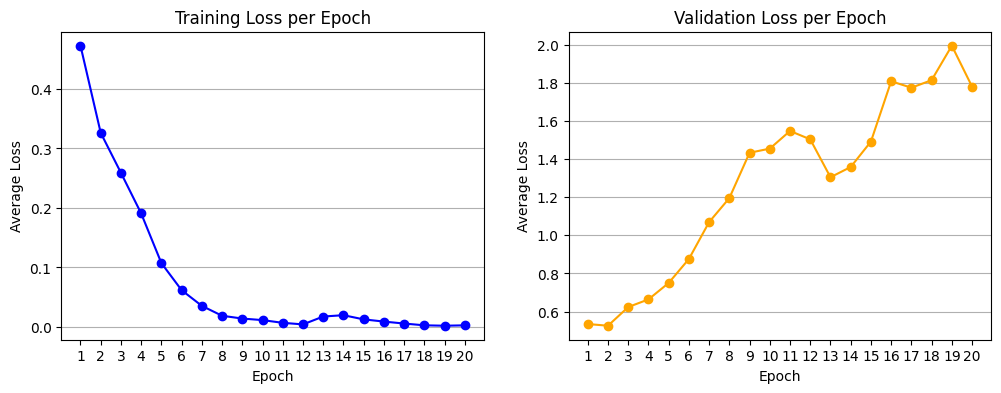

In [38]:
import matplotlib.pyplot as plt

epoch = range(1, shared.total_epoch + 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# Training Loss
axes[0].plot(epoch, train_epoch_losses, marker='o', color='blue', label='Train Loss')
axes[0].set_title('Training Loss per Epoch')
axes[0].set_xticks(epoch)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Average Loss')
axes[0].grid(axis='y')

# Validation Loss
axes[1].plot(epoch, val_epoch_losses, marker='o', color='orange')
axes[1].set_title('Validation Loss per Epoch')
axes[1].set_xticks(epoch)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Average Loss')
axes[1].grid(axis='y')

plt.show()

### 4.2.4 Evaluation

In summary, the model struggles to predict OOV words, regardless of how much content it has learned from the training set.

#### Training Loss

The training loss decreases rapidly and stabilizes around epoch 10, indicating that the model successfully fits the training data.

The consistent convergence pattern suggests that our vanilla RNN encoder-decoder is capable of capturing the sequence patterns within the training distribution, even without advanced mechanisms such as attention or pre-trained embeddings.

#### Validation Loss

The validation loss rises steadily throughout training, revealing a clear sign of overfitting.

This outcome is expected. Since the word-to-index vocabulary was intentionally built only from the training set

As a result, unseen or rare tokens are replaced by the \<UNK> tag, leading to higher loss and reduced generalization capability.

## 4.3 Model 2

In [80]:
# ============================================================
# Bi-LSTM with Attention for NLI Classification
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F

class NLI_BiLSTM_Attention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attn = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 8, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def attention_pool(self, lstm_out):
        # lstm_out: [batch, seq_len, hidden_dim*2]
        attn_weights = F.softmax(self.attn(lstm_out), dim=1)  # [batch, seq_len, 1]
        context = torch.sum(attn_weights * lstm_out, dim=1)   # [batch, hidden_dim*2]
        return context

    def forward(self, premise, hypothesis):
        # Encode premise
        prem_embed = self.embedding(premise)
        prem_out, _ = self.bilstm(prem_embed)
        prem_vec = self.attention_pool(prem_out)

        # Encode hypothesis
        hyp_embed = self.embedding(hypothesis)
        hyp_out, _ = self.bilstm(hyp_embed)
        hyp_vec = self.attention_pool(hyp_out)

        # Combine both representations
        combined = torch.cat([
            prem_vec,
            hyp_vec,
            torch.abs(prem_vec - hyp_vec),
            prem_vec * hyp_vec
        ], dim=1)  # [batch, hidden_dim*8]

        # Pass through classifier
        logits = self.fc(combined)
        return logits

In [81]:
# Assuming label_mapping and shared are already defined
# Define the number of classes from the label_mapping
label_mapping = {"neutral": 0, "entails": 1}
num_classes = len(label_mapping)
model = NLI_BiLSTM_Attention(
    vocab_size=len(vocab),
    embed_dim=shared.embed_dim,
    hidden_dim=shared.hidden_dim,
    num_classes=num_classes,
    pad_idx=shared.pad_idx
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=shared.learning_rate)

In [76]:
# Create test data loader
test_loader = make_batch(pad_test_df)

In [82]:
# Evaluate Model 2
model.eval()
all_labels = []
preds = []
with torch.no_grad():
    for prem, hypo, label in test_loader:
        prem, hypo, label = prem.to(device), hypo.to(device), label.to(device)
        outputs = model(prem, hypo)
        all_labels.append(label)
        preds.append(outputs)

all_labels = torch.cat(all_labels)
preds = torch.cat(preds)

              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00      1287
     entails       0.40      1.00      0.57       848

    accuracy                           0.40      2135
   macro avg       0.20      0.50      0.28      2135
weighted avg       0.16      0.40      0.23      2135



F:\Thonny\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
F:\Thonny\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
F:\Thonny\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


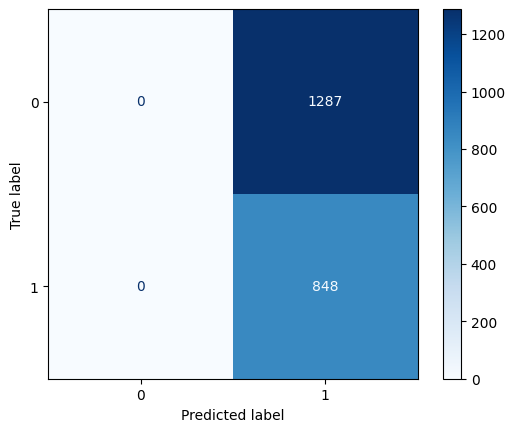

In [83]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_true = all_labels.cpu().numpy()
y_pred = preds.argmax(dim=1).cpu().numpy()

print(classification_report(y_true, y_pred, target_names=list(label_mapping.keys())))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap='Blues')

## 4.4 Model 3

# 5. Performance Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

# 6. Interactive Inference Colab Form
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)